In [49]:
#only (patient_id%NR_SHARDS) == SHARD_ID will be processed here
#choose a value between 1-NR_SHARDS
SHARD_ID = 1
IMAGE_W = 256
IMAGE_H = 256
IMAGE_D = 256

NR_SHARDS = 4
RANDOM_SEED = 0.1

#Patient DICOM images folder
INPUT_FOLDER = '../../input/sample_images/'
OUTPUT_FOLDER = '../../output/step3/' + str(SHARD_ID) + '/'
LABELS_FILE = '../../input/sample_labels.csv'

In [50]:
import csv
import h5py
from random import shuffle
import numpy as np # linear algebra
from numpy import ndarray
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import statistics
import csv
import dicom
import math
from time import time
import os
import shutil
import scipy.ndimage
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import scipy.ndimage as ndimage
from scipy.ndimage.interpolation import rotate
from scipy.ndimage.interpolation import shift
import itertools
from itertools import product, combinations
from skimage import measure, morphology, transform
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

In [51]:
class Timer:
    def __init__(self, name, debug=True):
        self._name = name
        self._debug = debug
        self.start()
    
    def start(self):
        self._start = time()
        if(self._debug):
            log('> [started] ' + self._name + '...')

    def stop(self):
        self._lastElapsed = (time()-self._start)
        if(self._debug):
            log('> [done]    {} ({:.3f} ms)'.format(self._name, self._lastElapsed*1000))
            
    def elapsed(self):
        if(self._lastElapsed != None):
            return (self._lastElapsed)
        else:
            return (time()-self._start)
        
import datetime
def log(message):
    print('{} {}'.format(datetime.datetime.now(), message))


In [52]:
# Load the scans in given folder path
#image pixels dimensions: z, y, x
def load_scan(path):
    t = Timer('load_scan ' + path)
    
    slices = [dicom.read_file(path + '/' + s) for s in os.listdir(path)]
    slices.sort(key = lambda x: int(x.ImagePositionPatient[2]))
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    except:
        slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)
        
    for s in slices:
        s.slice_thickness = slice_thickness

    t.stop()
    return slices

#image pixels dimensions: z, y, x
def get_pixels_hu(slices):
    image = np.stack([s.pixel_array for s in slices])
    # Convert to int16 (from sometimes int16), 
    # should be possible as values should always be low enough (<32k)
    image = image.astype(np.int16)

    # Set outside-of-scan pixels to 0
    # The intercept is usually -1024, so air is approximately 0
    image[image == -2000] = 0
    
    # Convert to Hounsfield units (HU)
    for slice_number in range(len(slices)):
        
        intercept = slices[slice_number].RescaleIntercept
        slope = slices[slice_number].RescaleSlope
        
        if slope != 1:
            image[slice_number] = slope * image[slice_number].astype(np.float64)
            image[slice_number] = image[slice_number].astype(np.int16)
            
        image[slice_number] += np.int16(intercept)
    
    return np.array(image, dtype=np.int16)

#image pixels dimensions: z, y, x
def resample(image, scan, new_spacing=[1,1,1]):
    t = Timer('resample')
    # Determine current pixel spacing
    spacing = np.array([scan[0].slice_thickness] + scan[0].PixelSpacing, dtype=np.float32)

    resize_factor = spacing / new_spacing
    new_real_shape = image.shape * resize_factor
    new_shape = np.round(new_real_shape)
    real_resize_factor = new_shape / image.shape
    new_spacing = spacing / real_resize_factor
    
    image = scipy.ndimage.interpolation.zoom(image, real_resize_factor, mode='nearest')
    t.stop()
    
    return image, new_spacing

def largest_label_volume(im, bg=-1):
    vals, counts = np.unique(im, return_counts=True)

    counts = counts[vals != bg]
    vals = vals[vals != bg]

    if len(counts) > 0:
        return vals[np.argmax(counts)]
    else:
        return None
    
def segment_lung_mask(image, fill_lung_structures=True):
    t = Timer('segment_lung_mask')

    # 0 is treated as background, which we do not want
    binary_image = np.array(image > -320, dtype=np.int8)+1
    labels = measure.label(binary_image)

    # Pick the pixel in the very corner to determine which label is air.
    #   Improvement: Pick multiple background labels from around the patient
    #   More resistant to "trays" on which the patient lays cutting the air 
    #   around the person in half
    background_label = labels[0,0,0] 
    
    #Fill the air around the person
    binary_image[background_label == labels] = 2

    # Method of filling the lung structures (that is superior to something like 
    # morphological closing)
    if fill_lung_structures:
        # For every slice we determine the largest solid structure
        for i, axial_slice in enumerate(binary_image):
            axial_slice = axial_slice - 1
            labeling = measure.label(axial_slice)
            l_max = largest_label_volume(labeling, bg=0)
            
            if l_max is not None: #This slice contains some lung
                binary_image[i][labeling != l_max] = 1
    
    binary_image -= 1 #Make the image actual binary
    binary_image = 1-binary_image # Invert it, lungs are now 1
    
    # Remove other air pockets insided body
    labels = measure.label(binary_image, background=0)
    
    l_max = largest_label_volume(labels, bg=0)
    if l_max is not None: # There are air pockets
        binary_image[labels != l_max] = 0

    #dilate mask
    binary_image = scipy.ndimage.morphology.grey_dilation(binary_image, size=(10,10,10))
    t.stop()
    
    return binary_image

#returns ((x1, y1, z1), (x2, y2, z2))
def bounding_box(img):
    N = img.ndim
    out = []
    for ax in itertools.combinations(range(N), N - 1):
        nonzero = np.any(img, axis=ax)
        out.extend(np.where(nonzero)[0][[0, -1]])
    r = np.reshape(np.asarray(tuple(out)), (-1, 2)).T
    return [tuple(r[0]), tuple(r[1])]

#return bounding box center in (x,y,z)
def bounding_box_center(bounds):
    return (int(round((bounds[0][0] + (bounds[1][0]-bounds[0][0])/2))), int(round((bounds[0][1] + (bounds[1][1]-bounds[0][1])/2))), int(round((bounds[0][2] + (bounds[1][2]-bounds[0][2])/2))))


In [53]:
#find lungs rotation by finding minimum and maximum extremities from lung halves
def find_minmax_halfx(lung_mask, xhalf, bottom2up=True, left2right=True, slicen=220):
    xsize = np.shape(lung_mask)[2]-1
    ysize = np.shape(lung_mask)[1]-1
    im = np.swapaxes(lung_mask[slicen], 0, 1)

    if(bottom2up): mvalue = (-1,0)
    else: mvalue = (-1, ysize)
        
    if(left2right): 
        xstart = 0
        xend = xhalf
        xdir = 1
    else:
        xstart = xsize
        xend = xhalf
        xdir = -1
        
    for x in range(xstart, xend, xdir):
        for y in range(ysize):
            if(not bottom2up): yi = ysize - y
            else: yi = y

            if(im[x][yi]>0.5):
                if(bottom2up and yi>mvalue[1]):
                    mvalue = (x, yi)
                elif(not bottom2up and yi<mvalue[1]):
                    mvalue = (x, yi)
    return mvalue
    
def calculate_angle(p1, p2):
    return math.degrees(math.atan2(p2[1]-p1[1],p2[0]-p1[0]))

def value_between(value, min_value, max_value):
    if(value<min_value): return False
    if(value>max_value): return False
    return True

def discover_lung_rotation(lung_mask):
    bbox = bounding_box(lung_mask)
    slicen = int((bbox[1][2]-bbox[0][2])/2)
    print('slice', slicen)
    half = int(bbox[0][0]+(bbox[1][0]-bbox[0][0])/2)

    l1 = find_minmax_halfx(lung_mask, half, bottom2up=True, left2right=True, slicen=slicen)
    r1 = find_minmax_halfx(lung_mask, half, bottom2up=True, left2right=False, slicen=slicen)
    l2 = find_minmax_halfx(lung_mask, half, bottom2up=False, left2right=True, slicen=slicen)
    r2 = find_minmax_halfx(lung_mask, half, bottom2up=False, left2right=False, slicen=slicen)

    r = (l1, r1, l2, r2)
    xs, ys = zip(*r)
    print(r)
    
    #verify points sanity
    if(not value_between(xs[1]-xs[0], 50, 200) or
       not value_between(xs[3]-xs[2], 50, 200) or
       not value_between(ys[0]-ys[2], 100, 250) or
       not value_between(ys[1]-ys[3], 100, 250)):
        print('Strange rotation detected. returning 0 degrees')
        return 0
    
    angle1 = calculate_angle(l1, r1)
    angle2 = calculate_angle(l2, r2)
    
    fig1, ax1 = plt.subplots(1)
    fig1.set_size_inches(2,2)
    ax1.imshow(lung_mask[slicen], cmap=plt.cm.gray)
    ax1.scatter(xs, ys)
    plt.show()
    
    a = ((angle1 + angle2)/2)
    return min(max(a, -10), 10)

In [54]:
def get_patient_ids(shard_id, input_dir):
    shard_patients = []
    
    file = csv.DictReader(open(LABELS_FILE))    
    for row in file:
        p = row['id']
        if(int(p,16)%NR_SHARDS == (shard_id-1)):
            shard_patients.append(p)
    log('found {} patients for shard {}'.format(len(shard_patients), shard_id))
    shuffle(shard_patients, lambda: RANDOM_SEED)
    return shard_patients

In [141]:
def generate_slice(patient_pixels, patient_id, slice_pos, output_dir):
    t = Timer('generate_slice ' + str(slice_pos))
    fig1, ax1 = plt.subplots(1)
    fig1.set_size_inches(6,6)
    ax1.imshow(patient_pixels[slice_pos], cmap=plt.cm.gray)
    file = output_dir + patient_id + '-' + 'slice-' + str(slice_pos) + '.jpg'
    plt.savefig(file)
        
#     plt.close(fig1)
    plt.show()
    t.stop()

In [142]:
def process_patient_label(input_dir, patient_id, output_dataset, dataset_row):
    labels = pd.read_csv(LABELS_FILE, index_col=0)
    value = labels.get_value(patient_id, 'cancer')
    #one-hot encoding
    label = np.array([0,1])
    if(value == 0): label = np.array([1,0])
    output_dataset[dataset_row] = label

In [143]:
def diff_for_shiffiting(point1, point2):
    t = np.subtract(point1, point2)
    return (t[2], t[1], t[0])

In [162]:
def process_patient_images(input_dir, patient_id, image_w, image_h, image_d, output_dataset, dataset_row, output_dir):
    patient_dir = input_dir + patient_id
    patient_scan = load_scan(patient_dir)
    patient_pixels = get_pixels_hu(patient_scan)
    patient_pixels, spacing = resample(patient_pixels, patient_scan, [1,1,1])
    patient_lung_mask = segment_lung_mask(patient_pixels, True)
    
    t = Timer('apply lung mask to image volume')
    patient_pixels = np.ma.masked_where(patient_lung_mask==0, patient_pixels)
    generate_slice(patient_pixels, patient_id, round(np.shape(patient_pixels)[0]/2), output_dir)
    t.stop()

    t = Timer('rotate image for optimal pose')
    rotation_angle = discover_lung_rotation(patient_lung_mask)
    if(abs(rotation_angle)<10):
        patient_pixels = rotate(patient_pixels,rotation_angle,(1,2), reshape=False)
    else:
        print('Angle too large. Skipping rotation. angle=', rotation_angle)    
    print('patient_pixels_rotated', np.shape(patient_pixels))
    generate_slice(patient_pixels, patient_id, round(np.shape(patient_pixels)[0]/2), output_dir)
    t.stop()
    
    t = Timer('resize image volume to {}x{}x{}'.format(image_w, image_h, image_d))
    bbox = bounding_box(patient_lung_mask)
    bbox_center = bounding_box_center(bbox)
    ratio_w = image_w/(bbox[1][0]-bbox[0][0])
    ratio_h = image_h/(bbox[1][1]-bbox[0][1])
    ratio_d = image_d/(bbox[1][2]-bbox[0][2])
    ratio = max((ratio_w, ratio_h, ratio_d))
    print('ratios=', ratio_w, ratio_h, ratio_d)
#     patient_pixels = transform.rescale(patient_pixels, [ratio_d,ratio_h,ratio_w])
    patient_pixels = scipy.ndimage.interpolation.zoom(patient_pixels[bbox[0][2]:bbox[1][2],bbox[0][1]:bbox[1][1],bbox[0][0]:bbox[1][0]], ratio, mode='nearest')

    print('patient_pixels_resized_centered', np.shape(patient_pixels))
    t.stop()

#     t = Timer('translate image for optimal center')
#     print('bbox_center', bbox_center)
#     bbox_center = tuple(np.multiply(bbox_center, [ratio_w, ratio_h, ratio_d]))
#     bbox_center = tuple(map(lambda x: isinstance(x, float) and round(x) or x, bbox_center))
#     print('bbox_center', bbox_center)
#     diff = diff_for_shiffiting((round(image_w*ratio_w), round(image_h*ratio_h), round(image_d*ratio_d)), bbox_center)
#     patient_pixels = shift(patient_pixels,shift=diff)
#     print('patient_pixels_resized_centered', np.shape(patient_pixels))
#     t.stop()

    t = Timer('crop to final image size')
    pw = round((np.shape(patient_pixels)[2]-image_w)/2)
    ph = round((np.shape(patient_pixels)[1]-image_h)/2)
    pd = round((np.shape(patient_pixels)[0]-image_d)/2)
    patient_pixels = patient_pixels[pd:image_d-pd, ph:image_h-ph, pw:image_w-pw]
    print('patient_pixels_cropped', np.shape(patient_pixels))
    t.stop()

    generate_slice(patient_pixels, patient_id, round(np.shape(patient_pixels)[0]/2), output_dir)
    

In [163]:
def start_processing(input_dir, shard_id, max_patients, image_w, image_h, image_d, output_dir):
    log('Processing patients. shard_id=' + str(shard_id) + ' max_patients='+ str(max_patients) + ' input_dir=' + input_dir + ' output_dir=' + output_dir)
    
    log('Gathering patient ids for this shard')
    patient_ids = get_patient_ids(shard_id, input_dir)
    total_patients = len(patient_ids)
    
    log('Preparing output dir')
    shutil.rmtree(output_dir, True)
    try:
        os.makedirs(output_dir)
    except:
        print('Ops! Couldnt create output dir')
        pass
    
    log('Creating datasets')
    h5f = h5py.File(output_dir + 'data-centered-rotated-{}-{}-{}.h5'.format(image_w, image_h, image_d), 'w')
    x_ds = h5f.create_dataset('X', (total_patients, image_d, image_h, image_w), chunks=(2, image_d, image_h, image_w), dtype='f')
    y_ds = h5f.create_dataset('Y', (total_patients, 2), chunks=(2, 2), dtype='f')

    log('Starting to process each patient (count={})'.format(len(patient_ids)))
    count = 0

    for patient_id in patient_ids:
        if(count>max_patients):
            break

        t = Timer('>>> PATIENT PROCESSING ' + patient_id + ' (count=' + str(count) + '; output_dir=' + output_dir + ')')
        process_patient_images(input_dir, patient_id, image_w, image_h, image_d, x_ds, count, output_dir)
        process_patient_label(input_dir, patient_id, y_ds, count)
        t.stop()
        count = count + 1
        print('')
        
    h5f.close()

==== PROCESSING SHARD 1 ====
2017-02-14 15:10:14.725183 Processing patients. shard_id=1 max_patients=1 input_dir=../../input/sample_images/ output_dir=../../output/step3/1/
2017-02-14 15:10:14.725221 Gathering patient ids for this shard
2017-02-14 15:10:14.726410 found 3 patients for shard 1
2017-02-14 15:10:14.726519 Preparing output dir
2017-02-14 15:10:14.727484 Creating datasets
2017-02-14 15:10:14.728511 Starting to process each patient (count=3)
2017-02-14 15:10:14.728570 > [started] >>> PATIENT PROCESSING 0a099f2549429d29b32f349e95fb2244 (count=0; output_dir=../../output/step3/1/)...
2017-02-14 15:10:14.728599 > [started] load_scan ../../input/sample_images/0a099f2549429d29b32f349e95fb2244...
2017-02-14 15:10:14.836272 > [done]    load_scan ../../input/sample_images/0a099f2549429d29b32f349e95fb2244 (107.658 ms)
2017-02-14 15:10:14.986778 > [started] resample...
2017-02-14 15:10:32.651607 > [done]    resample (17664.801 ms)
2017-02-14 15:10:32.651954 > [started] segment_lung_mask

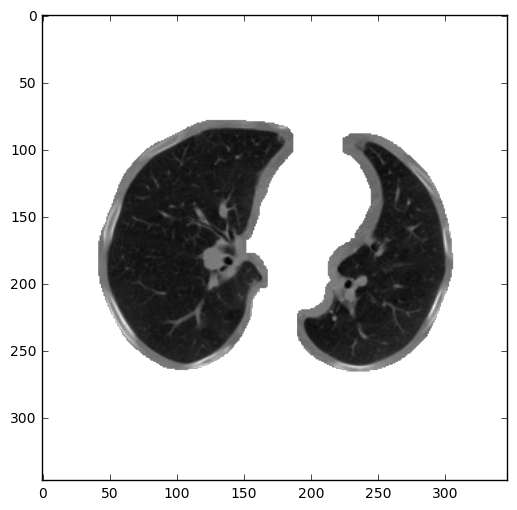

2017-02-14 15:10:39.575085 > [done]    generate_slice 160 (338.897 ms)
2017-02-14 15:10:39.575138 > [done]    apply lung mask to image volume (538.898 ms)
2017-02-14 15:10:39.575165 > [started] rotate image for optimal pose...
slice 145
((94, 263), (238, 265), (124, 77), (174, 82))


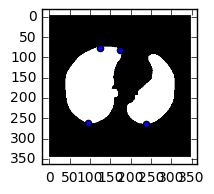

patient_pixels_rotated (320, 347, 347)
2017-02-14 15:10:45.450403 > [started] generate_slice 160...


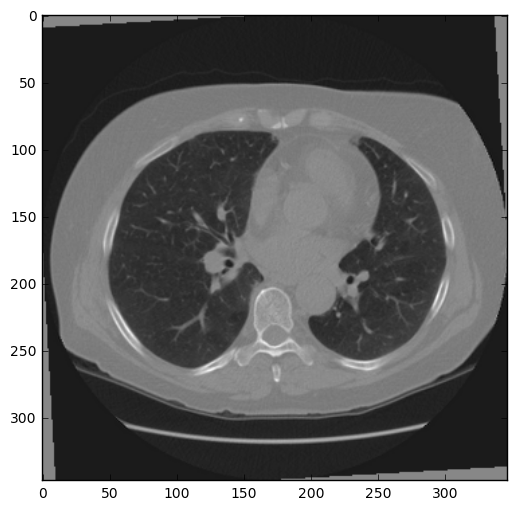

2017-02-14 15:10:45.836701 > [done]    generate_slice 160 (386.278 ms)
2017-02-14 15:10:45.837145 > [done]    rotate image for optimal pose (6261.972 ms)
2017-02-14 15:10:45.837186 > [started] resize image volume to 256x256x256...
ratios= 0.853333333333 1.33333333333 0.88275862069


/opt/conda/lib/python3.5/site-packages/scipy/ndimage/interpolation.py:568: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


patient_pixels_resized_centered (387, 256, 400)
2017-02-14 15:11:00.828367 > [done]    resize image volume to 256x256x256 (14991.161 ms)
2017-02-14 15:11:00.828426 > [started] crop to final image size...
patient_pixels_cropped (124, 256, 112)
2017-02-14 15:11:00.828485 > [done]    crop to final image size (0.056 ms)
2017-02-14 15:11:00.828514 > [started] generate_slice 62...


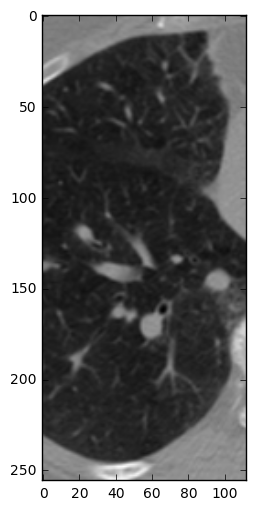

2017-02-14 15:11:01.217319 > [done]    generate_slice 62 (388.790 ms)
2017-02-14 15:11:01.225004 > [done]    >>> PATIENT PROCESSING 0a099f2549429d29b32f349e95fb2244 (count=0; output_dir=../../output/step3/1/) (46496.416 ms)

2017-02-14 15:11:01.225076 > [started] >>> PATIENT PROCESSING 0c9d8314f9c69840e25febabb1229fa4 (count=1; output_dir=../../output/step3/1/)...
2017-02-14 15:11:01.225113 > [started] load_scan ../../input/sample_images/0c9d8314f9c69840e25febabb1229fa4...
2017-02-14 15:11:01.406371 > [done]    load_scan ../../input/sample_images/0c9d8314f9c69840e25febabb1229fa4 (181.251 ms)
2017-02-14 15:11:01.730717 > [started] resample...
2017-02-14 15:11:21.644766 > [done]    resample (19914.025 ms)
2017-02-14 15:11:21.649492 > [started] segment_lung_mask...
2017-02-14 15:11:28.208478 > [done]    segment_lung_mask (6558.958 ms)
2017-02-14 15:11:28.219444 > [started] apply lung mask to image volume...
2017-02-14 15:11:28.447858 > [started] generate_slice 199...


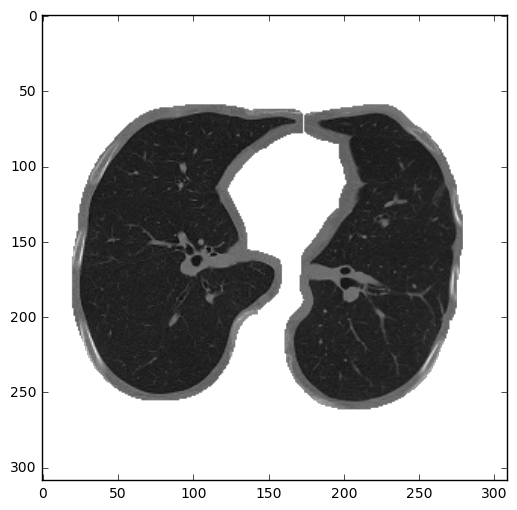

2017-02-14 15:11:28.838722 > [done]    generate_slice 199 (390.856 ms)
2017-02-14 15:11:28.838774 > [done]    apply lung mask to image volume (619.346 ms)
2017-02-14 15:11:28.838800 > [started] rotate image for optimal pose...
slice 177
((65, 254), (223, 260), (90, 59), (226, 61))


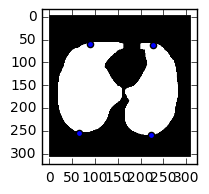

patient_pixels_rotated (398, 309, 309)
2017-02-14 15:11:35.006644 > [started] generate_slice 199...


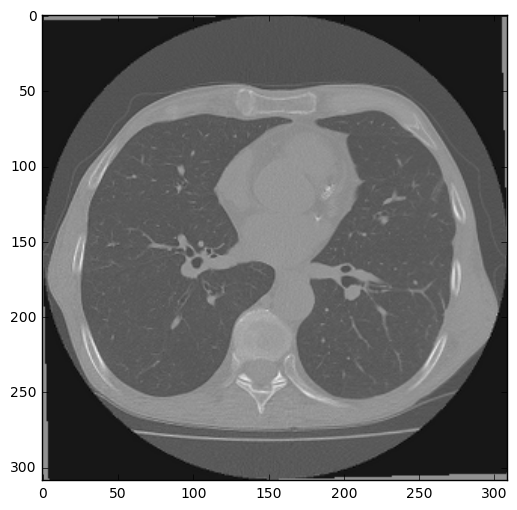

2017-02-14 15:11:35.406163 > [done]    generate_slice 199 (399.520 ms)
2017-02-14 15:11:35.406227 > [done]    rotate image for optimal pose (6567.425 ms)
2017-02-14 15:11:35.406255 > [started] resize image volume to 256x256x256...
ratios= 0.91103202847 1.26108374384 0.723163841808
patient_pixels_resized_centered (446, 256, 354)
2017-02-14 15:11:50.422815 > [done]    resize image volume to 256x256x256 (15016.537 ms)
2017-02-14 15:11:50.422882 > [started] crop to final image size...
patient_pixels_cropped (66, 256, 158)
2017-02-14 15:11:50.422936 > [done]    crop to final image size (0.052 ms)
2017-02-14 15:11:50.422964 > [started] generate_slice 33...


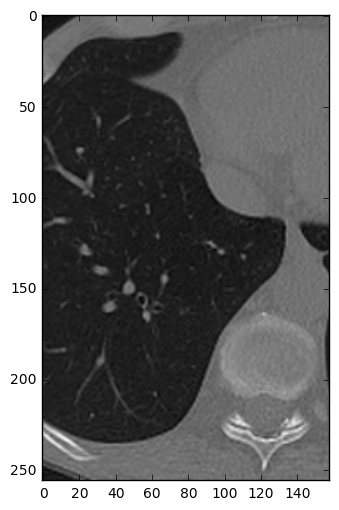

2017-02-14 15:11:50.769302 > [done]    generate_slice 33 (346.322 ms)
2017-02-14 15:11:50.779301 > [done]    >>> PATIENT PROCESSING 0c9d8314f9c69840e25febabb1229fa4 (count=1; output_dir=../../output/step3/1/) (49554.167 ms)

==== ALL DONE ====


In [164]:
print('==== PROCESSING SHARD ' + str(SHARD_ID) + ' ====')
start_processing(INPUT_FOLDER, SHARD_ID, 1, IMAGE_W, IMAGE_H, IMAGE_D, OUTPUT_FOLDER)
print('==== ALL DONE ====')